In [2]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
# 设置显示字体为 Times New Roman
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams["axes.unicode_minus"] = False

#图像清晰度调整
%config InlineBackend.figure_format = 'retina'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork, LastLevelMaxPool

class FPN(nn.Module):
    def __init__(self, num_classes=1, pretrained_backbone=True, backbone_weights_path=None):
        super(FPN, self).__init__()
        # 使用ResNet-50作为FPN的骨干网络
        backbone = resnet50(pretrained=False)  # 设置为不自动下载预训练模型
        if pretrained_backbone and backbone_weights_path:
            backbone.load_state_dict(torch.load(backbone_weights_path))  # 加载指定路径的权重文件

        # 保留 ResNet-50 的初始层（包含卷积、BN、ReLU 和 max pooling）
        self.initial_layers = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )

        # 定义 FPN 需要的不同分辨率特征图
        self.backbone_layers = nn.ModuleDict({
            'layer1': backbone.layer1,  # 输出通道数为256
            'layer2': backbone.layer2,  # 输出通道数为512
            'layer3': backbone.layer3,  # 输出通道数为1024
            'layer4': backbone.layer4   # 输出通道数为2048
        })
        
        # FPN 定义，in_channels_list 对应各层的输出通道数
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[256, 512, 1024, 2048],  # 对应每一层的输出通道数
            out_channels=256,
            extra_blocks=LastLevelMaxPool()
        )
        
        # 最终分类头
        self.classifier = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        # 通过初始层处理输入图像
        x = self.initial_layers(x)
        
        # 提取不同层级的特征
        features = {}
        for name, layer in self.backbone_layers.items():
            x = layer(x)
            features[name] = x

        # 将特征输入FPN
        fpn_outs = self.fpn(features)

        # 获取 P3 层输出用于最终的二分类分割
        p3_out = fpn_outs['layer1']  # 使用 layer1 输出作为主分辨率
        output = self.classifier(p3_out)
        
        # 上采样到原始图像尺寸
        output = F.interpolate(output, scale_factor=4, mode="bilinear", align_corners=False)
        return output

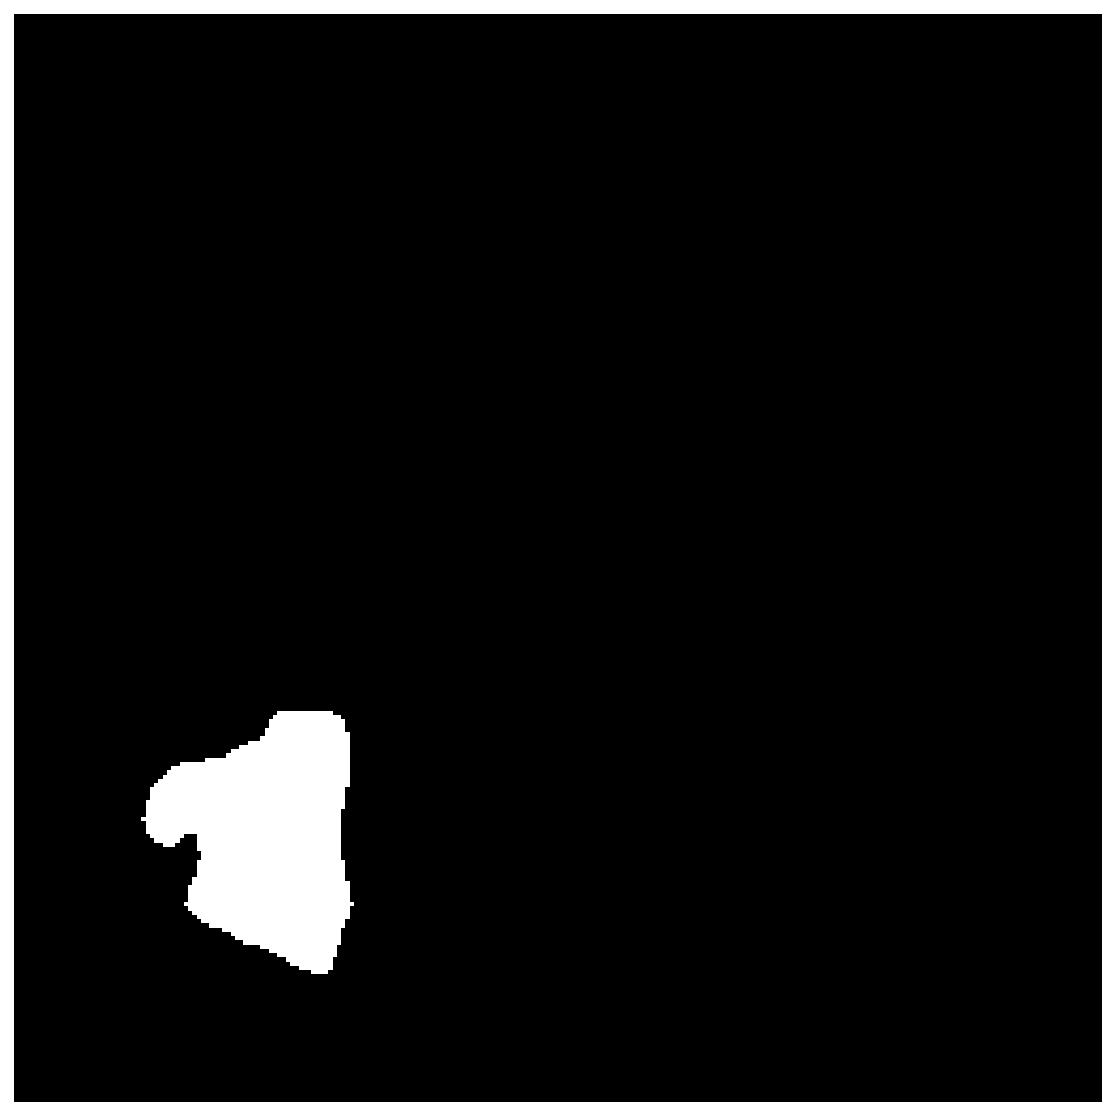

In [23]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

# 移除 Pillow 对图像大小的限制
Image.MAX_IMAGE_PIXELS = None

# 加载保存的模型
def load_model(model_path, device):
    model = FPN().to(device)  # 使用之前定义的 SimpleUNet 模型架构
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
    model.eval()  # 设置为评估模式
    return model

# 定义测试函数
def test_model(model, test_image_path, transform, device):
    # 加载测试图像
    image = Image.open(test_image_path).convert('RGB')  # 转换为RGB格式
    original_size = image.size  # 获取原始图像大小
    image = transform(image).unsqueeze(0)  # 应用transform并增加batch维度
    image = image.to(device)

    # 进行预测
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # 使用sigmoid激活函数
        predicted_mask = (output > 0.5).float()  # 将输出转换为二值掩码

        # 调整输出掩码为原始图像的大小
        predicted_mask = F.interpolate(predicted_mask, size=original_size[::-1], mode='bilinear', align_corners=False)
        
        # 确保插值后的掩码也是二值化（再进行一次二值化）
        predicted_mask = (predicted_mask > 0.5).float()

    return predicted_mask

# 将预测的掩码部分标红并叠加到原图上（半透明红色）
def apply_mask_on_image(image_path, predicted_mask, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()

    # 创建红色的遮罩层
    red_mask = np.zeros_like(image_np, dtype=np.uint8)
    red_mask[:, :, 0] = 255  # 将红色通道设为 255 (RGB)

    # 叠加红色遮罩到原图上，使用 alpha 实现半透明效果
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * red_mask[predicted_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

# 可视化测试结果并保存黑白掩码图像
def visualize_results(original_image_path, image_with_mask, predicted_mask):
    # 只显示黑白二值化掩码
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # 转换为 NumPy 格式

    # 显示二值化掩码
    plt.figure(figsize=(10, 10))

    # 黑白二值化掩码
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    # 保存图像到桌面
    output_path = '/Users/camus/Desktop/predicted_binary_mask.png'  # 保存路径
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

    # 显示图像
    plt.show()

# 设置测试参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'FPN_model.pth'  # 你训练好的模型路径
# test_image_path = '/Users/camus/Desktop/虫害/part1.jpg'  # 你的测试图像路径
# test_image_path = '/Users/camus/Desktop/trainX/image/image-124.png'  # 你的测试图像路径

test_image_path = '/Users/camus/Desktop/trainX/image/image-216.png'  # 你的测试图像路径
# test_image_path = '/Users/camus/Desktop/1.png'  # 你的测试图像路径

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 加载模型
model = load_model(model_path, device)

# 运行测试
predicted_mask = test_model(model, test_image_path, transform, device)

# 将预测的掩码部分标红
image_with_mask = apply_mask_on_image(test_image_path, predicted_mask)

# 可视化结果
visualize_results(test_image_path, image_with_mask, predicted_mask)

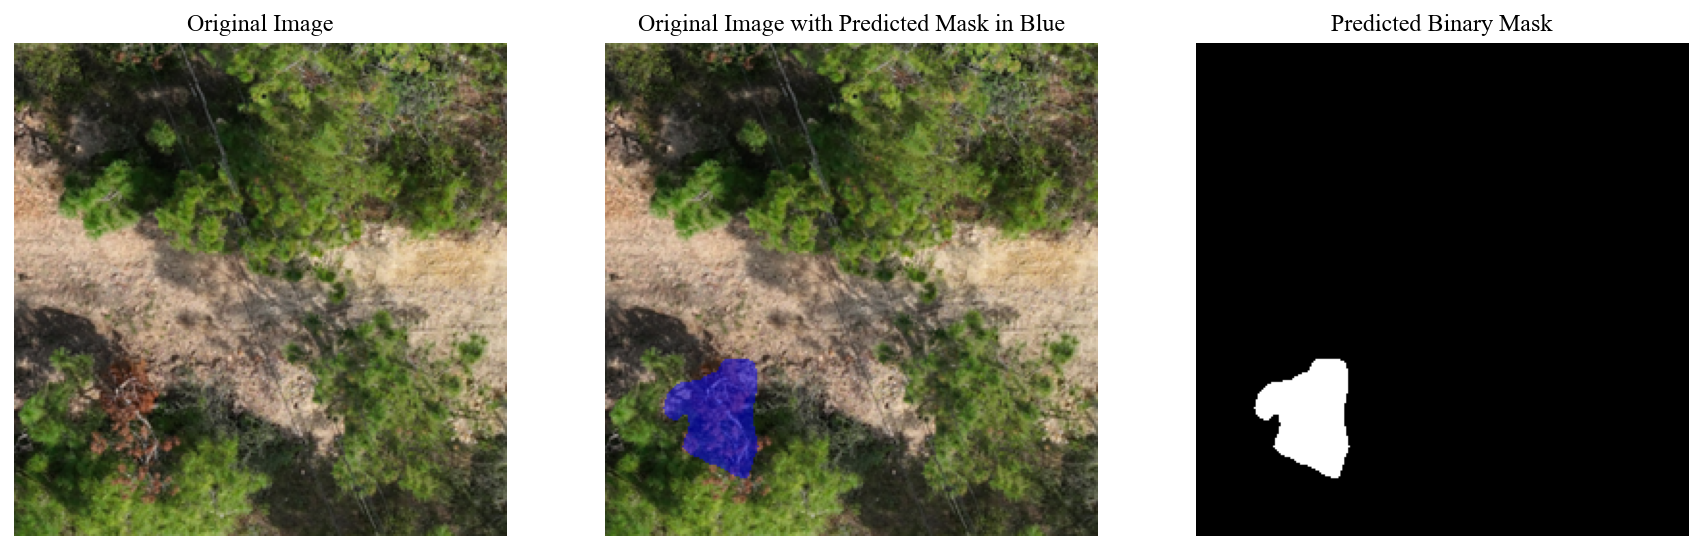

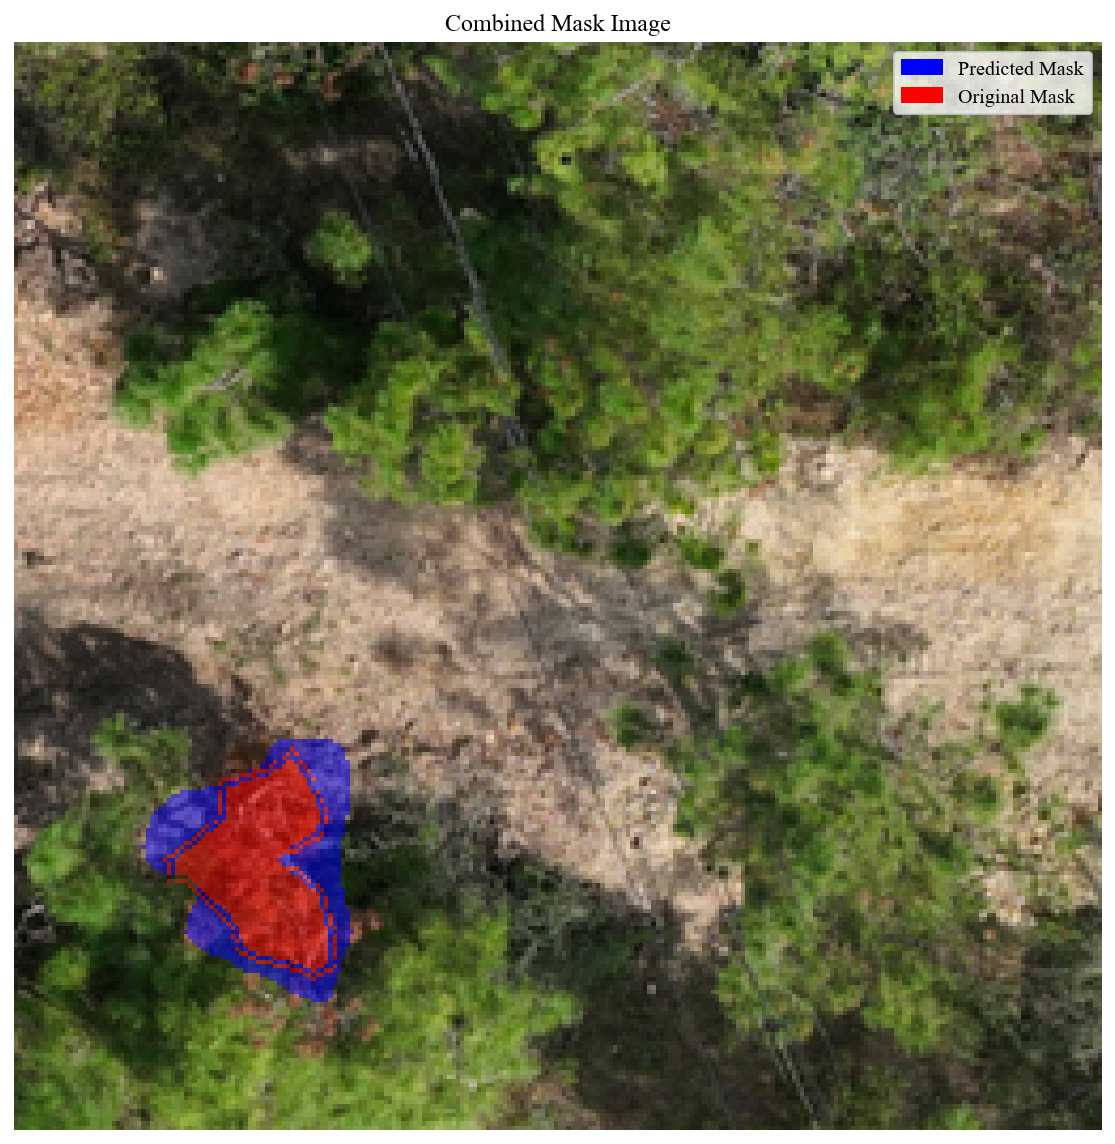

In [24]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import matplotlib.patches as mpatches

# 移除 Pillow 对图像大小的限制
Image.MAX_IMAGE_PIXELS = None

# 加载保存的模型
def load_model(model_path, device):
    model = FPN().to(device)  # 使用之前定义的 SimpleUNet 模型架构
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
    model.eval()  # 设置为评估模式
    return model

# 定义测试函数
def test_model(model, test_image_path, transform, device):
    # 加载测试图像
    image = Image.open(test_image_path).convert('RGB')  # 转换为RGB格式
    original_size = image.size  # 获取原始图像大小
    image = transform(image).unsqueeze(0)  # 应用transform并增加batch维度
    image = image.to(device)

    # 进行预测
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # 使用sigmoid激活函数
        predicted_mask = (output > 0.5).float()  # 将输出转换为二值掩码

        # 调整输出掩码为原始图像的大小
        predicted_mask = F.interpolate(predicted_mask, size=original_size[::-1], mode='bilinear', align_corners=False)
        
        # 确保插值后的掩码也是二值化（再进行一次二值化）
        predicted_mask = (predicted_mask > 0.5).float()

    return predicted_mask

# 将预测掩码部分标蓝并叠加到原图上（蓝色掩码）
def apply_mask_on_image_with_blue(image_path, predicted_mask, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()

    # 创建蓝色的遮罩层
    blue_mask = np.zeros_like(image_np, dtype=np.uint8)
    blue_mask[:, :, 2] = 255  # 将蓝色通道设为 255 (RGB)

    # 叠加蓝色遮罩到原图上，使用 alpha 实现半透明效果
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * blue_mask[predicted_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

# 将预测掩码和原始掩码叠加在原图上，分别以蓝色和红色透明显示
def apply_mask_on_image_with_alpha(image_path, predicted_mask, original_mask_path, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码和原始掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()
    original_mask = Image.open(original_mask_path).convert('L')
    original_mask = np.array(original_mask.resize(image_np.shape[:2][::-1])) / 255  # 归一化

    # 创建蓝色和红色的遮罩层
    blue_mask = np.zeros_like(image_np, dtype=np.uint8)
    blue_mask[:, :, 2] = 255  # 将蓝色通道设为 255
    red_mask = np.zeros_like(image_np, dtype=np.uint8)
    red_mask[:, :, 0] = 255  # 将红色通道设为 255

    # 叠加蓝色（预测掩码）和红色（原始掩码）的透明遮罩
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * blue_mask[predicted_mask == 1]
    image_with_mask[original_mask == 1] = (1 - alpha) * image_np[original_mask == 1] + alpha * red_mask[original_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

# 单独显示蓝红叠加图并添加图例注释
def show_combined_mask_image_with_legend(image_with_mask):
    plt.figure(figsize=(10, 10))  # 调整图像大小
    plt.imshow(image_with_mask)
    plt.title("Combined Mask Image")
    plt.axis('off')

    # 创建图例注释
    blue_patch = mpatches.Patch(color='blue', label='Predicted Mask')
    red_patch = mpatches.Patch(color='red', label='Original Mask')
    plt.legend(handles=[blue_patch, red_patch], loc='upper right')  # 图例位置在右上角

    plt.show()

# 可视化测试结果
def visualize_results(original_image_path, image_with_blue_mask, predicted_mask):
    original_image = Image.open(original_image_path)
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # 转换为 NumPy 格式

    # 显示三张图片
    plt.figure(figsize=(15, 5))

    # 原图
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # 蓝色掩码叠加图
    plt.subplot(1, 3, 2)
    plt.imshow(image_with_blue_mask)
    plt.title("Original Image with Predicted Mask in Blue")
    plt.axis('off')

    # 黑白二值化掩码
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Binary Mask")
    plt.axis('off')

    # 显示所有图像
    plt.show()

# 设置测试参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'FPN_model.pth'  # 你训练好的模型路径
test_image_path = '/Users/camus/Desktop/trainX/image/image-216.png'  # 你的测试图像路径
original_mask_path = '/Users/camus/Desktop/trainX/maskimage/image-216.png'  # 原始掩码图像路径

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 加载模型
model = load_model(model_path, device)

# 运行测试
predicted_mask = test_model(model, test_image_path, transform, device)

# 将预测的掩码部分标蓝
image_with_blue_mask = apply_mask_on_image_with_blue(test_image_path, predicted_mask)

# 可视化结果
visualize_results(test_image_path, image_with_blue_mask, predicted_mask)

# 生成叠加有透明蓝红掩码的图像
image_with_mask = apply_mask_on_image_with_alpha(test_image_path, predicted_mask, original_mask_path)

# 显示结果并添加注释
show_combined_mask_image_with_legend(image_with_mask)

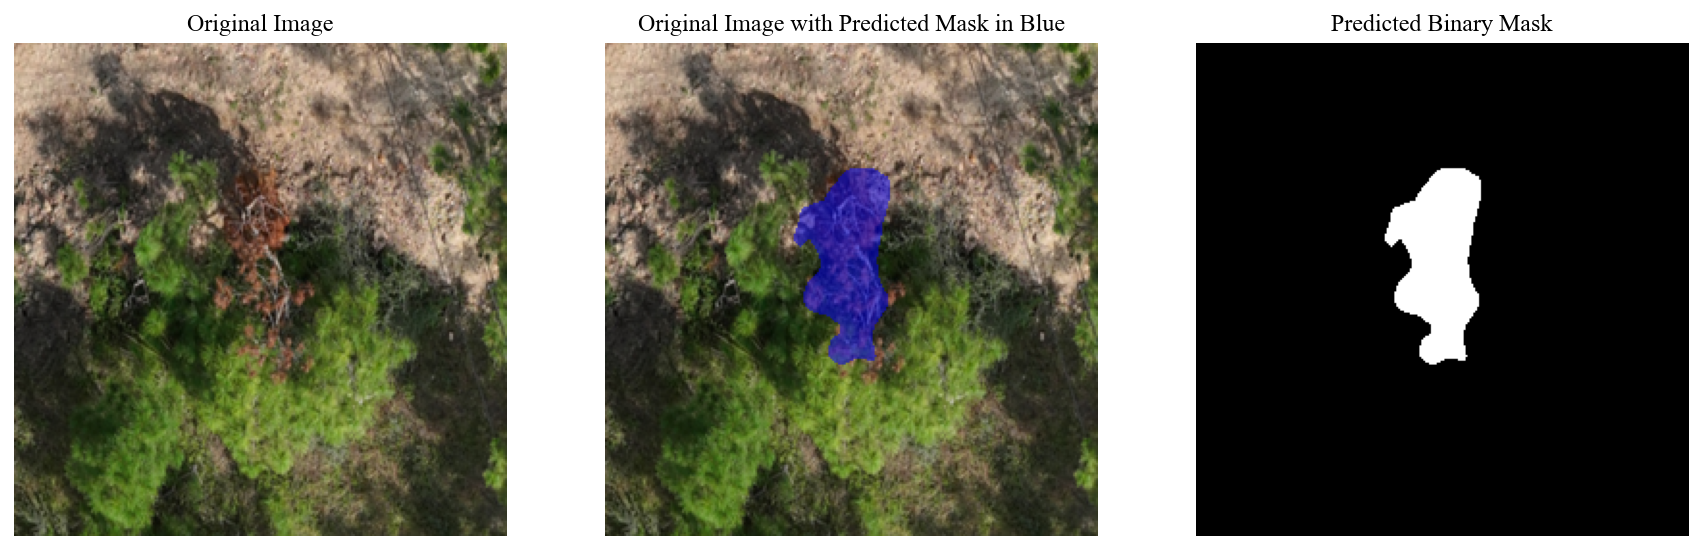

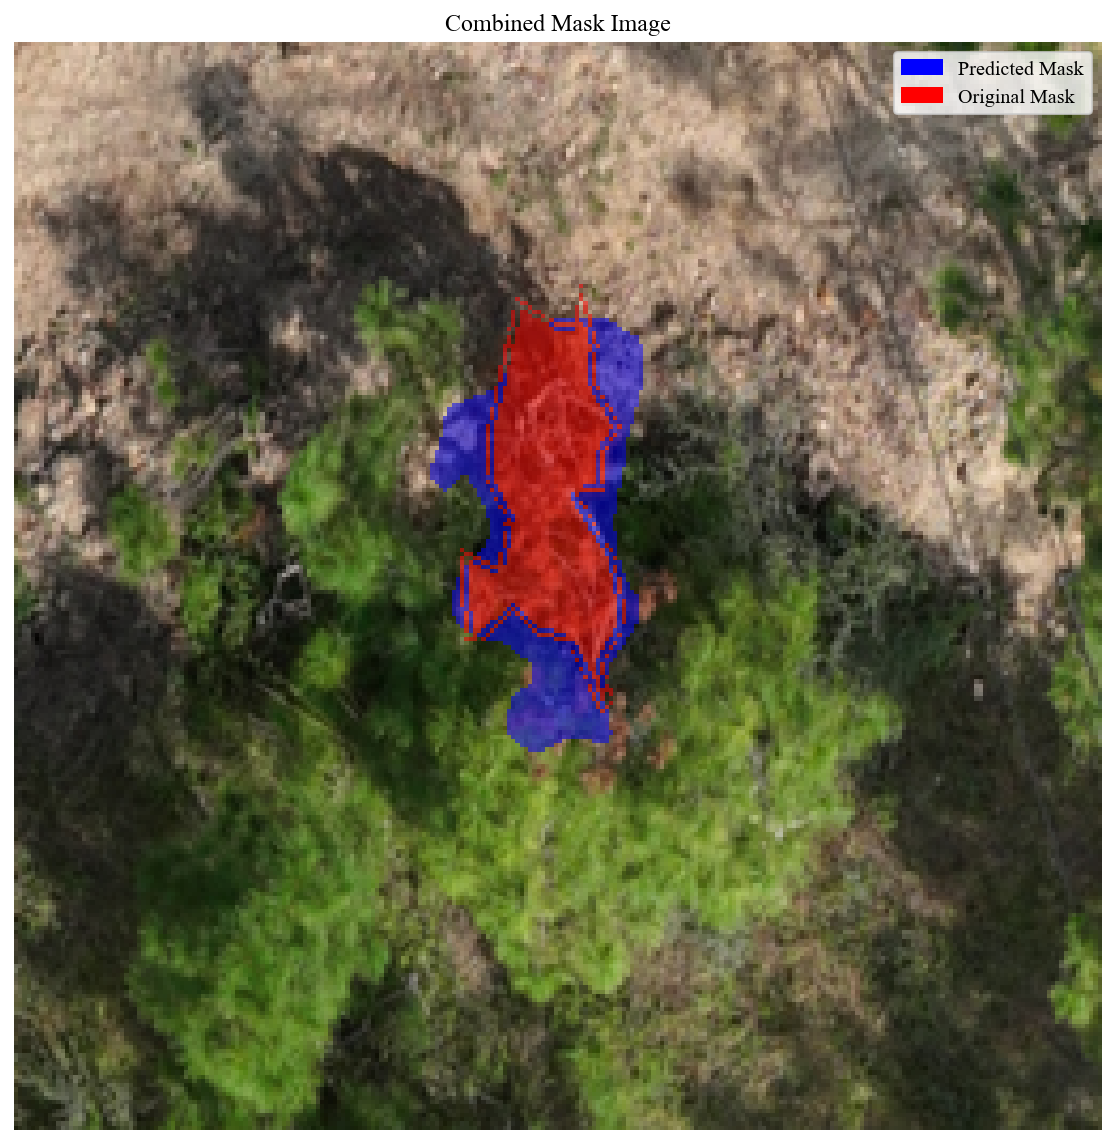

In [6]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import matplotlib.patches as mpatches

# 移除 Pillow 对图像大小的限制
Image.MAX_IMAGE_PIXELS = None

# 加载保存的模型
def load_model(model_path, device):
    model = FPN().to(device)  # 使用之前定义的 FPN 模型架构
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
    model.eval()  # 设置为评估模式
    return model

# 定义测试函数
def test_model(model, test_image_path, transform, device):
    # 加载测试图像
    image = Image.open(test_image_path).convert('RGB')  # 转换为RGB格式
    original_size = image.size  # 获取原始图像大小
    image = transform(image).unsqueeze(0)  # 应用transform并增加batch维度
    image = image.to(device)

    # 进行预测
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # 使用sigmoid激活函数
        predicted_mask = (output > 0.5).float()  # 将输出转换为二值掩码

        # 调整输出掩码为原始图像的大小
        predicted_mask = F.interpolate(predicted_mask, size=original_size[::-1], mode='bilinear', align_corners=False)
        
        # 确保插值后的掩码也是二值化（再进行一次二值化）
        predicted_mask = (predicted_mask > 0.5).float()

    return predicted_mask

# 将预测掩码部分标蓝并叠加到原图上（蓝色掩码）
def apply_mask_on_image_with_blue(image_path, predicted_mask, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()

    # 创建蓝色的遮罩层
    blue_mask = np.zeros_like(image_np, dtype=np.uint8)
    blue_mask[:, :, 2] = 255  # 将蓝色通道设为 255 (RGB)

    # 叠加蓝色遮罩到原图上，使用 alpha 实现半透明效果
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * blue_mask[predicted_mask == 1]

    # 保存结果到桌面
    output_path = '/Users/camus/Desktop/blue_mask_image.png'
    Image.fromarray(np.uint8(image_with_mask)).save(output_path)

    return Image.fromarray(np.uint8(image_with_mask))

# 将预测掩码和原始掩码叠加在原图上，分别以蓝色和红色透明显示
def apply_mask_on_image_with_alpha(image_path, predicted_mask, original_mask_path, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码和原始掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()
    original_mask = Image.open(original_mask_path).convert('L')
    original_mask = np.array(original_mask.resize(image_np.shape[:2][::-1])) / 255  # 归一化

    # 创建蓝色和红色的遮罩层
    blue_mask = np.zeros_like(image_np, dtype=np.uint8)
    blue_mask[:, :, 2] = 255  # 将蓝色通道设为 255
    red_mask = np.zeros_like(image_np, dtype=np.uint8)
    red_mask[:, :, 0] = 255  # 将红色通道设为 255

    # 叠加蓝色（预测掩码）和红色（原始掩码）的透明遮罩
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * blue_mask[predicted_mask == 1]
    image_with_mask[original_mask == 1] = (1 - alpha) * image_np[original_mask == 1] + alpha * red_mask[original_mask == 1]

    # 保存结果到桌面
    output_path = '/Users/camus/Desktop/combined_mask_image.png'
    Image.fromarray(np.uint8(image_with_mask)).save(output_path)

    return Image.fromarray(np.uint8(image_with_mask))

# 单独显示蓝红叠加图并添加图例注释
def show_combined_mask_image_with_legend(image_with_mask):
    plt.figure(figsize=(10, 10))  # 调整图像大小
    plt.imshow(image_with_mask)
    plt.title("Combined Mask Image")
    plt.axis('off')

    # 创建图例注释
    blue_patch = mpatches.Patch(color='blue', label='Predicted Mask')
    red_patch = mpatches.Patch(color='red', label='Original Mask')
    plt.legend(handles=[blue_patch, red_patch], loc='upper right')  # 图例位置在右上角

    # 保存图像到桌面
    output_path = '/Users/camus/Desktop/combined_mask_with_legend.png'
    plt.savefig(output_path)
    plt.show()

# 可视化测试结果
def visualize_results(original_image_path, image_with_blue_mask, predicted_mask):
    original_image = Image.open(original_image_path)
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # 转换为 NumPy 格式

    # 显示三张图片
    plt.figure(figsize=(15, 5))

    # 原图
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # 蓝色掩码叠加图
    plt.subplot(1, 3, 2)
    plt.imshow(image_with_blue_mask)
    plt.title("Original Image with Predicted Mask in Blue")
    plt.axis('off')

    # 黑白二值化掩码
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Binary Mask")
    plt.axis('off')

    # 保存图像到桌面
    output_path = '/Users/camus/Desktop/results_visualization.png'
    plt.savefig(output_path)
    plt.show()

# 设置测试参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'FPN_model.pth'  # 你训练好的模型路径
test_image_path = '/Users/camus/Desktop/trainX/image/image-107.png'  # 你的测试图像路径
original_mask_path = '/Users/camus/Desktop/trainX/maskimage/image-107.png'  # 原始掩码图像路径

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 加载模型
model = load_model(model_path, device)

# 运行测试
predicted_mask = test_model(model, test_image_path, transform, device)

# 将预测的掩码部分标蓝
image_with_blue_mask = apply_mask_on_image_with_blue(test_image_path, predicted_mask)

# 可视化结果
visualize_results(test_image_path, image_with_blue_mask, predicted_mask)

# 生成叠加有透明蓝红掩码的图像
image_with_mask = apply_mask_on_image_with_alpha(test_image_path, predicted_mask, original_mask_path)

# 显示结果并添加注释
show_combined_mask_image_with_legend(image_with_mask)

Test Accuracy: 0.9812


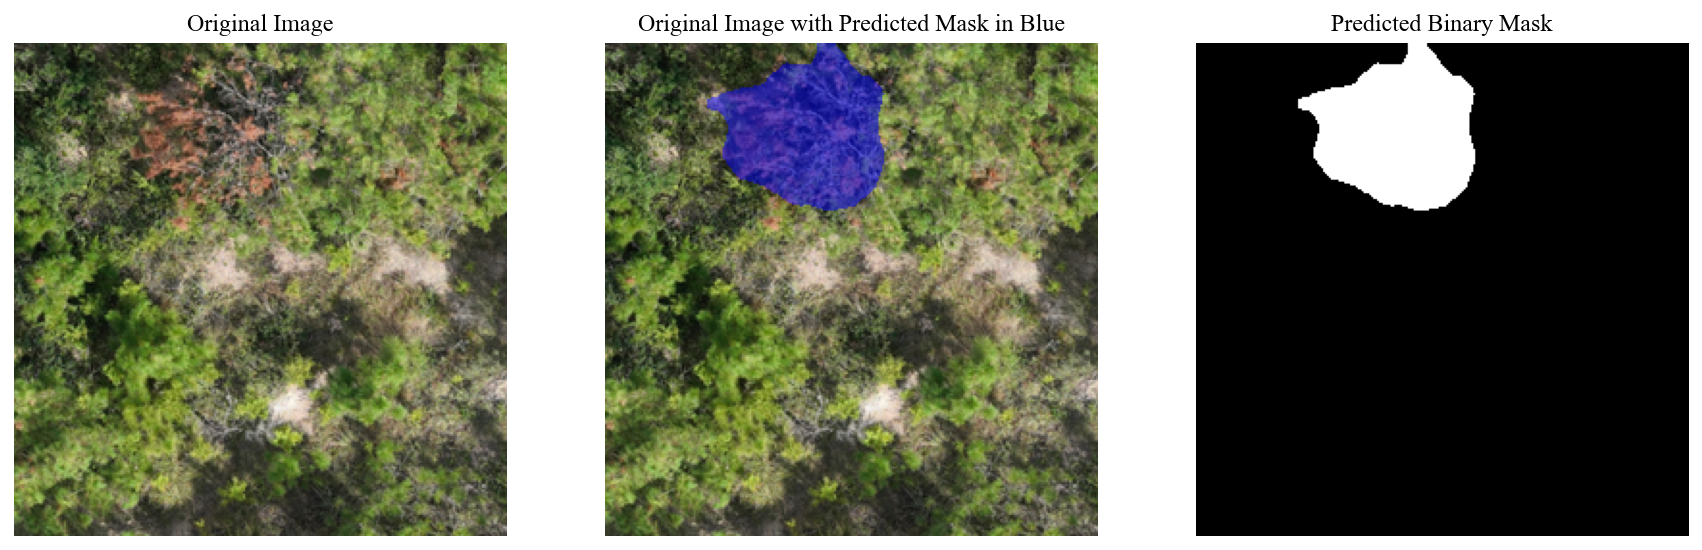

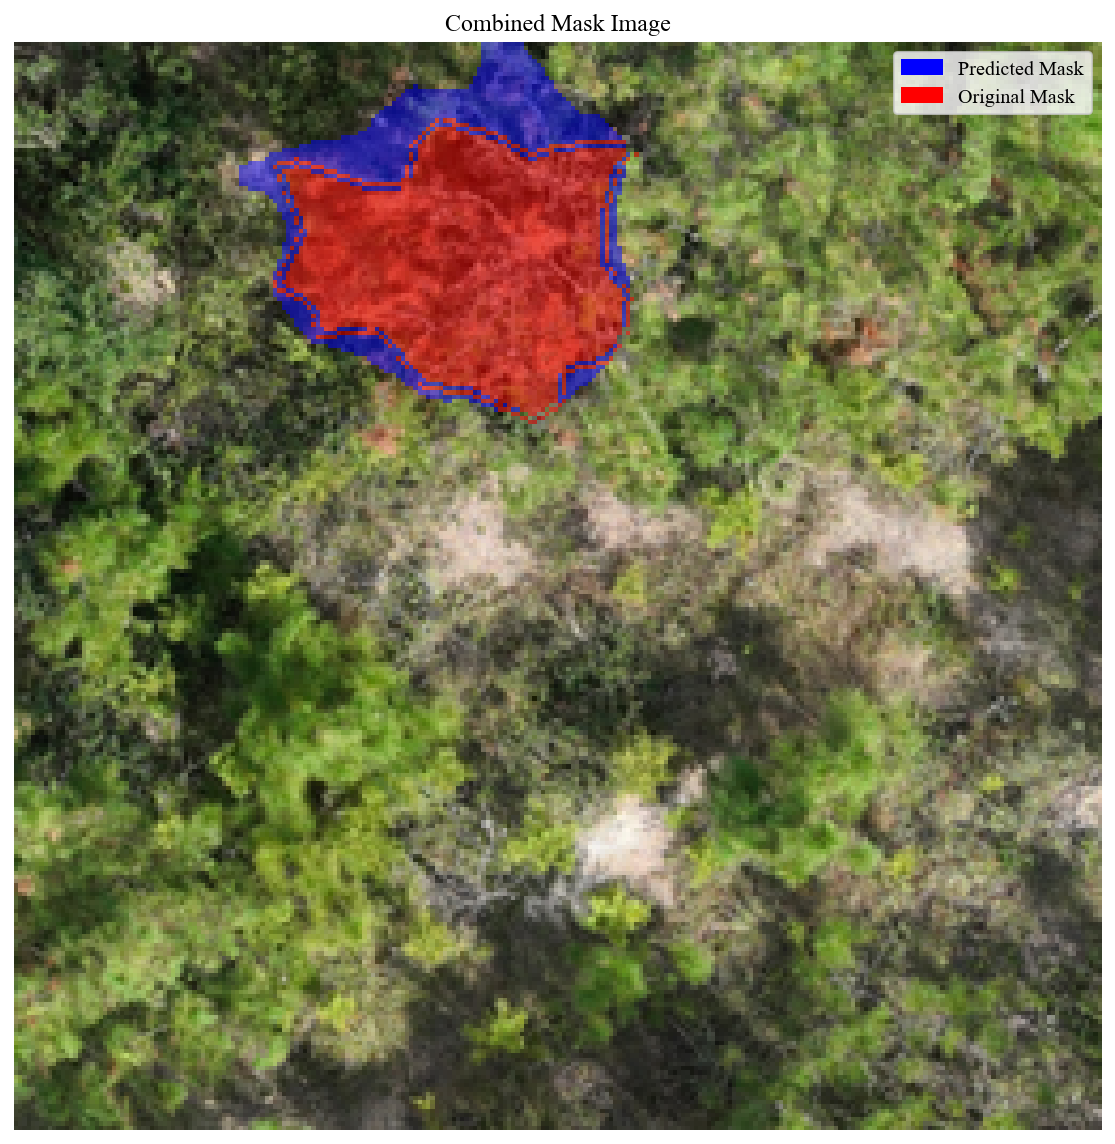

In [6]:
# 计算准确率
def calculate_test_accuracy(predicted_mask, original_mask_path):
    # 将预测的掩码和原始掩码转换为 NumPy 数组
    predicted_mask = predicted_mask.squeeze().cpu().numpy()
    original_mask = Image.open(original_mask_path).convert('L')
    original_mask = np.array(original_mask.resize(predicted_mask.shape[::-1])) / 255  # 归一化为0和1

    # 转换为布尔数组，便于计算
    predicted_mask = predicted_mask > 0.5
    original_mask = original_mask > 0.5

    # 计算总像素数和预测正确的像素数
    total_pixels = np.prod(predicted_mask.shape)
    correct_pixels = np.sum(predicted_mask == original_mask)

    # 计算准确率
    accuracy = correct_pixels / total_pixels
    return accuracy

# 修改后的测试函数，加入准确率计算
def test_model_with_accuracy(model, test_image_path, transform, original_mask_path, device):
    # 加载测试图像
    image = Image.open(test_image_path).convert('RGB')  # 转换为RGB格式
    original_size = image.size  # 获取原始图像大小
    image = transform(image).unsqueeze(0)  # 应用transform并增加batch维度
    image = image.to(device)

    # 进行预测
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # 使用sigmoid激活函数
        predicted_mask = (output > 0.5).float()  # 将输出转换为二值掩码

        # 调整输出掩码为原始图像的大小
        predicted_mask = F.interpolate(predicted_mask, size=original_size[::-1], mode='bilinear', align_corners=False)
        
        # 确保插值后的掩码也是二值化（再进行一次二值化）
        predicted_mask = (predicted_mask > 0.5).float()

    # 计算准确率
    accuracy = calculate_test_accuracy(predicted_mask, original_mask_path)
    return predicted_mask, accuracy

# 使用新的测试函数
predicted_mask, accuracy = test_model_with_accuracy(model, test_image_path, transform, original_mask_path, device)

# 输出准确率
print(f"Test Accuracy: {accuracy:.4f}")

# 可视化结果
image_with_blue_mask = apply_mask_on_image_with_blue(test_image_path, predicted_mask)
visualize_results(test_image_path, image_with_blue_mask, predicted_mask)

# 显示叠加透明蓝红掩码图像
image_with_mask = apply_mask_on_image_with_alpha(test_image_path, predicted_mask, original_mask_path)
show_combined_mask_image_with_legend(image_with_mask)

In [17]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn.functional as F

# 移除 Pillow 对图像大小的限制
Image.MAX_IMAGE_PIXELS = None

# 加载保存的模型
def load_model(model_path, device):
    """
    加载模型
    """
    model = FPN().to(device)  # 使用之前定义的 FPN 模型架构
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
    model.eval()  # 设置为评估模式
    return model

# 定义测试函数
def test_model(model, test_image_path, transform, device):
    """
    测试模型，返回预测掩码
    """
    image = Image.open(test_image_path).convert('RGB')  # 转换为 RGB 格式
    original_size = image.size  # 获取原始图像大小
    image = transform(image).unsqueeze(0)  # 应用 transform 并增加 batch 维度
    image = image.to(device)

    # 进行预测
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # 使用 sigmoid 激活函数
        predicted_mask = (output > 0.5).float()  # 将输出转换为二值掩码

        # 调整输出掩码为原始图像的大小
        predicted_mask = F.interpolate(predicted_mask, size=original_size[::-1], mode='bilinear', align_corners=False)
        predicted_mask = (predicted_mask > 0.5).float()  # 确保插值后的掩码也是二值化

    return predicted_mask

# 将预测掩码部分标蓝并叠加到原图上（蓝色掩码）
def apply_mask_on_image_with_blue(image_path, predicted_mask, alpha=0.5):
    """
    叠加蓝色掩码到原图上
    """
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # 转换为 NumPy 格式

    # 创建蓝色的遮罩层
    blue_mask = np.zeros_like(image_np, dtype=np.uint8)
    blue_mask[:, :, 2] = 255  # 将蓝色通道设为 255

    # 叠加蓝色遮罩到原图上，使用 alpha 实现半透明效果
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * blue_mask[predicted_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

# 将预测掩码和原始掩码叠加在原图上，分别以蓝色和红色透明显示
def apply_mask_on_image_with_alpha(image_path, predicted_mask, original_mask_path, alpha=0.5):
    """
    叠加蓝色和红色掩码到原图上
    """
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    predicted_mask = predicted_mask.squeeze().cpu().numpy()
    original_mask = Image.open(original_mask_path).convert('L')
    original_mask = np.array(original_mask.resize(image_np.shape[:2][::-1])) / 255  # 归一化

    # 创建蓝色和红色的遮罩层
    blue_mask = np.zeros_like(image_np, dtype=np.uint8)
    blue_mask[:, :, 2] = 255  # 将蓝色通道设为 255
    red_mask = np.zeros_like(image_np, dtype=np.uint8)
    red_mask[:, :, 0] = 255  # 将红色通道设为 255

    # 叠加蓝色（预测掩码）和红色（原始掩码）的透明遮罩
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * blue_mask[predicted_mask == 1]
    image_with_mask[original_mask == 1] = (1 - alpha) * image_np[original_mask == 1] + alpha * red_mask[original_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

import matplotlib.pyplot as plt

# 使用 matplotlib 保存蓝色掩码叠加图像
def save_image_with_blue_mask(image_with_blue_mask, save_path):
    """
    保存蓝色掩码叠加图像，设置尺寸为 1000x1000 像素，DPI 为 500
    """
    plt.figure(figsize=(2, 2), dpi=500)  # 设置 figsize，使 2 inches x 500 DPI = 1000 像素
    plt.imshow(image_with_blue_mask)
    plt.axis('off')  # 去掉坐标轴
    plt.savefig(save_path, dpi=500, bbox_inches='tight', pad_inches=0)  # 保存为 500 DPI
    plt.close()

# 使用 matplotlib 保存蓝红掩码叠加图像
def save_combined_mask_image(image_with_mask, save_path):
    """
    保存蓝红掩码叠加图像，设置尺寸为 1000x1000 像素，DPI 为 500
    """
    plt.figure(figsize=(2, 2), dpi=500)  # 设置 figsize，使 2 inches x 500 DPI = 1000 像素
    plt.imshow(image_with_mask)
    plt.axis('off')  # 去掉坐标轴
    plt.savefig(save_path, dpi=500, bbox_inches='tight', pad_inches=0)  # 保存为 500 DPI
    plt.close()

# 主测试流程
if __name__ == "__main__":
    # 设置测试参数
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = 'FPN_model.pth'  # 你训练好的模型路径
    test_image_path = '/Users/camus/Desktop/trainX/image/image-215.png'  # 测试图像路径
    original_mask_path = '/Users/camus/Desktop/trainX/maskimage/image-215.png'  # 原始掩码图像路径

    # 图像预处理
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    # 加载模型
    model = load_model(model_path, device)

    # 运行测试
    predicted_mask = test_model(model, test_image_path, transform, device)

    # 生成蓝色掩码叠加图像
    image_with_blue_mask = apply_mask_on_image_with_blue(test_image_path, predicted_mask)
    save_image_with_blue_mask(image_with_blue_mask, "/Users/camus/Desktop/image_with_blue_mask.png")

    # 生成蓝红掩码叠加图像
    image_with_mask = apply_mask_on_image_with_alpha(test_image_path, predicted_mask, original_mask_path)
    save_combined_mask_image(image_with_mask, "/Users/camus/Desktop/combined_mask_image.png")

